## Armchair Graphene Nanoribbon

## Import statements

In [19]:
import kwant
import tinyarray
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

from ipywidgets import interact

## Builder functions

In [2]:
class Rectangle:
    """
    Class to define callable objects to define the 
    shape of the scattering region of a rectangular
    system.
    """
    def __init__(self, W, L):
        '''
        Calling the scattering region as strip:
        W = width of the strip
        L = length of the strip 
        '''
        self.W = W
        self.L = L
        
    def __call__(self, pos):
        W, L = self.W, self.L
        x, y = pos
        return 0 <= y <= W and 0 <= x <= L
    
    def leads(self, pos):
        W = self.W
        _, y = pos
        return 0 <= y <= W

In [3]:
def make_whole_system(lat, W, L, V):
    shape_syst = Rectangle(W, L)
    syst = make_graphene_armchair(lat, shape_syst, V)
    leads = make_lead_armchair(lat, shape_syst.leads, V)
    for lead in leads:
        syst.attach_lead(lead)
    return syst, leads

def make_graphene_armchair(lattice, shape_syst, V):
    syst = kwant.Builder()
    syst[lattice.shape(shape_syst, (0,0))] = V
    syst[lattice.neighbors()] = hopping_peierls
    return syst

def make_lead_armchair(lattice, shape_lead, V):
    a, b = lattice.sublattices
    symmetry = kwant.TranslationalSymmetry(lattice.vec((-1,-1)))
    symmetry.add_site_family(a, other_vectors=[(1,-1)])
    symmetry.add_site_family(b, other_vectors=[(1,-1)])
    
    lead_0 = kwant.Builder(symmetry)
    lead_0[lattice.shape(shape_lead, (0,0))] = V
    lead_0[lattice.neighbors()] = hopping_peierls
    
    lead_1 = lead_0.reversed()
    
    return lead_0, lead_1

def hopping_peierls(Site1, Site2, t, B):
    return -t * peierls(Site1, Site2, B)

def peierls(Site1, Site2, B):
    (x_i, y_i) = Site1.pos       # Target
    (x_j, y_j) = Site2.pos       # Source
    theta = B/2 * (x_i - x_j) * (y_i + y_j)
    return np.exp(1j*theta)

## Make the system

In [24]:
cos_30, sin_30 = np.cos(np.pi/6), np.sin(np.pi/6)
lat = kwant.lattice.general(
        [(cos_30, sin_30), (cos_30, -sin_30)],
        [(0,0), (np.sqrt(3)/3, 0)],
        norbs=1,
        name='ArmGraph')

a, b = lat.sublattices
system, leads = make_whole_system(lat, W=50,L=10,V=0)

In [25]:
def family_colors(site):
    return 'w' if site.family == a else 'k' if site.family == b else 'r'

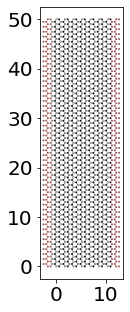

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_aspect('equal')
ax.tick_params(labelsize=20)
kwant.plot(system, num_lead_cells=1, site_color=family_colors, site_lw=0.1, ax=ax)

## Band structure

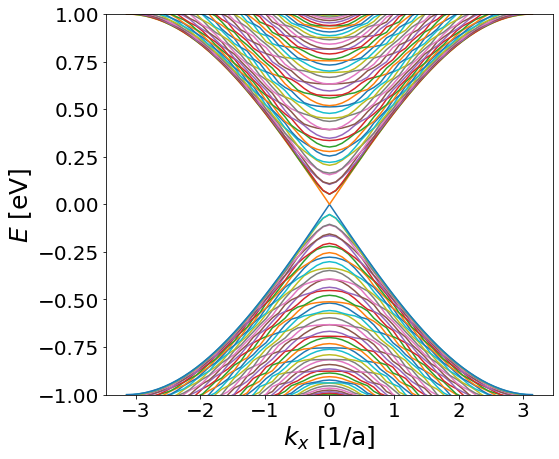

In [28]:
fig, ax = plt.subplots(figsize=(8,7))
ax.tick_params(labelsize=20)
ax.set_xlabel(r'$k_x$ [1/a]', fontsize=25)
ax.set_ylabel(r'$E$ [eV]', fontsize=25)
ax.set_ylim(-1,1)
kwant.plotter.bands(leads[0].finalized(), params=dict(B=0, t=1), ax=ax);

## Landau fan chart

In [29]:
magnetic_field_values_graphene = np.linspace(0, 0.1, 1001)

energies_graphene_armchair = []

for Bfield in magnetic_field_values_graphene:
    parameters = dict(B=Bfield, t=1)
    bands = kwant.physics.Bands(leads[0].finalized(), params=parameters)
    energies_graphene_armchair.append(bands(0))

(0.0, 0.1)

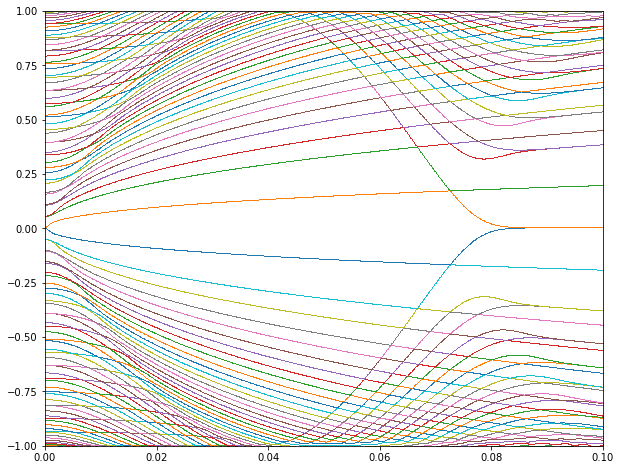

In [30]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(magnetic_field_values_graphene, energies_graphene_armchair, ',');
ax.set_ylim(-1, 1)
ax.set_xlim(0, .1)

In [35]:
def plot_bands(B):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_ylim(-1,1)
    kwant.plotter.bands(leads[0].finalized(), momenta=201, params=dict(B=B, t=1), ax=ax)

In [38]:
interact(plot_bands, B=(-0.1,0.1,0.001))

interactive(children=(FloatSlider(value=0.0, description='B', max=0.1, min=-0.1, step=0.001), Output()), _dom_…

<function __main__.plot_bands(B)>

In [92]:
bands_magn = kwant.physics.Bands(leads[0].finalized(), params=dict(B=0.01, t=1))

In [93]:
kx_bands = np.linspace(-1,1,201)
band_values = np.array([bands_magn(k) for k in kx_bands])

(-1.0, 1.0)

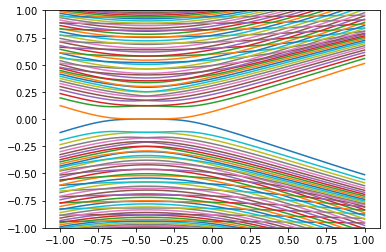

In [94]:
plt.plot(kx_bands, band_values)
plt.ylim(-1,1)

In [95]:
def extreme_values(bands_values):
    extrema_bands = []
    for band in bands_values.T:
        minimum = np.min(band)
        maximum = np.max(band)
        if np.abs(minimum) > np.abs(maximum):
            extrema_bands.append(maximum)
        else:
            extrema_bands.append(minimum)
    return np.array(extrema_bands)

In [96]:
extr_bands_0 = extreme_values(band_values)

In [97]:
extr_bands_0.shape

(202,)

(-1.0, 1.0)

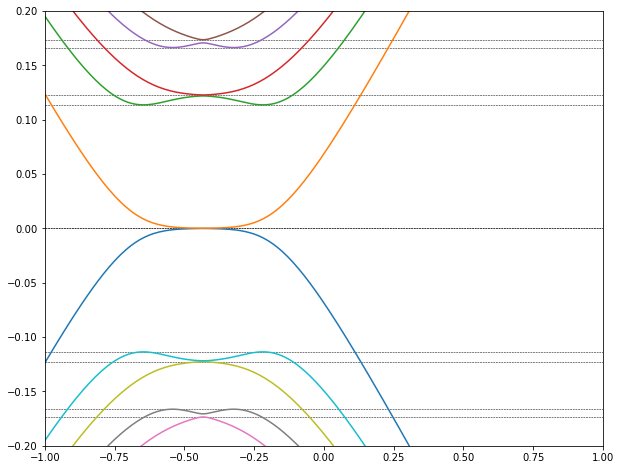

In [103]:
plt.figure(figsize=(10,8))
plt.plot(kx_bands, band_values)
plt.hlines(y=extr_bands_0, xmax=1, xmin=-1, lw=0.5, ls='--')
plt.ylim(-0.2, 0.2)
plt.xlim(-1,1)

In [86]:
B_values = np.arange(0, 0.15, 0.001)

levels = []
for Bfield in B_values:
    bands_Bfield = kwant.physics.Bands(leads[0].finalized(), params=dict(B=Bfield, t=1))
    band_values_Bfield = np.array([bands_Bfield(k) for k in kx_bands])
    levels.append(extreme_values(band_values_Bfield))

(-0.8, 0.8)

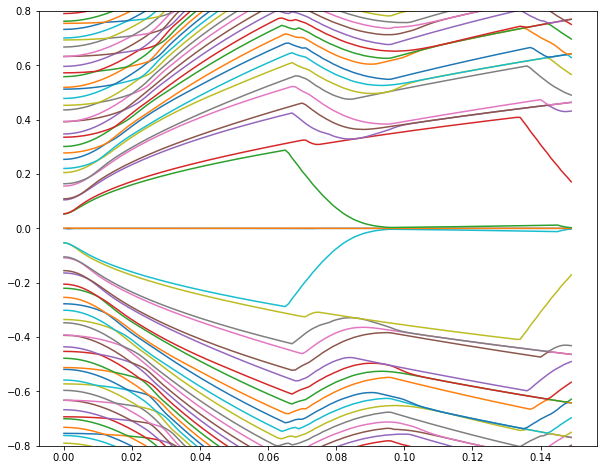

In [91]:
plt.figure(figsize=(10,8))
plt.plot(B_values, levels);
plt.ylim(-.8,.8)

## Transport

In [172]:
## Conductance
def calculate_conductance(syst, energy_values, params_dict):
    syst = syst.finalized()
    data = []
    for energy in energy_values:
        # compute the scattering matrix at a given energy
        smatrix = kwant.smatrix(syst, energy, params=params_dict)
        # compute the transmission probability from lead 0 to
        # lead 1
        data.append(smatrix.transmission(1, 0))
    return np.array(data)

In [173]:
energy_values = np.linspace(0,2,300)
transmission0 = calculate_conductance(system, energy_values, params_dict=dict(B=0, t=1))

In [174]:
transmission1 = calculate_conductance(system, energy_values, params_dict=dict(B=0.1, t=1))

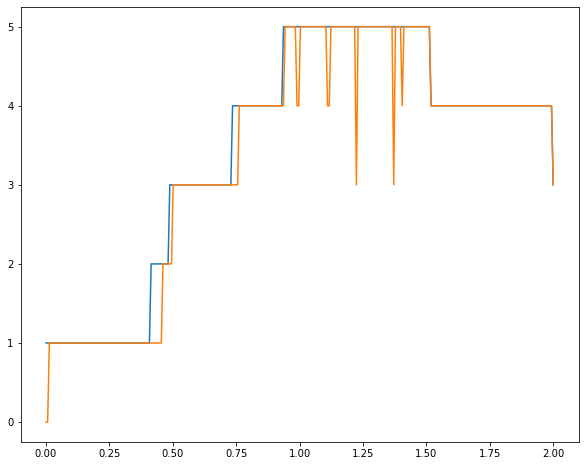

In [175]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(energy_values, transmission0)
ax.plot(energy_values, transmission1)
plt.show()

## Density of states

In [176]:
fsystem = system.finalized() ## Finalize the system
spectrum0 = kwant.kpm.SpectralDensity(fsystem, params=dict(B=0, t=1))
spectrum1 = kwant.kpm.SpectralDensity(fsystem, params=dict(B=0.1, t=1))

In [177]:
energies0, densities0 = spectrum0()
energies1, densities1 = spectrum1()

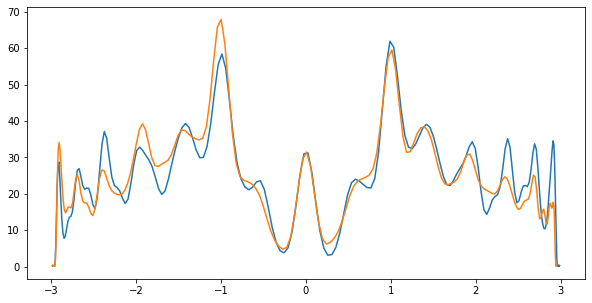

In [178]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(energies0, densities0)
ax.plot(energies1, densities1)
plt.show()

## Local density of states

In [179]:
kwant_op = kwant.operator.Density(fsystem, sum=False)
local_dos = kwant.kpm.SpectralDensity(fsystem, operator=kwant_op, params=dict(B=0, t=1))
local_dos.add_vectors(100)

In [182]:
zero_energy_ldos = local_dos(energy=0)

In [ ]:
def family_shape(i):
        site = syst.sites[i]
        return ('p', 3, 180) if site.family == a else ('p', 3, 0)

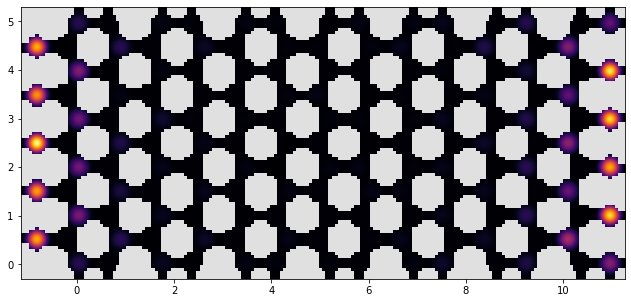

In [186]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
kwant.plotter.density(fsystem, zero_energy_ldos.real, ax=axes, cmap='inferno')

In [199]:
ham = fsystem.hamiltonian_submatrix(params=dict(B=0,t=1))
evecs = la.eigh(ham)[1]

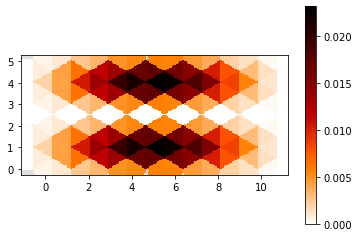

In [203]:
wf = abs(evecs[:, 3])**2
kwant.plotter.map(fsystem, wf, oversampling=10, cmap='gist_heat_r');

## Tests

In [70]:
cos_30, sin_30 = np.cos(np.pi/6), np.sin(np.pi/6)

graphene_custom = kwant.lattice.general(
    [(cos_30, sin_30), (cos_30, -sin_30)],
    [(0,0), (np.sqrt(3)/3, 0)],
    name='ArmGraph'
)

In [71]:
shape_test = Rectangle(W=5, L=10)

In [72]:
system_test = make_graphene_armchair(graphene_custom, shape_test, V=0, t=1)

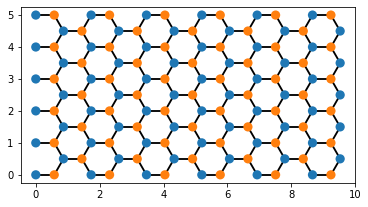

In [73]:
kwant.plot(system_test);

In [75]:
a, b = graphene_custom.sublattices

symmetry_test = kwant.TranslationalSymmetry(graphene_custom.vec((-1,-1)))
symmetry_test.add_site_family(a, other_vectors=[(+1,-1)])
symmetry_test.add_site_family(b, other_vectors=[(+1,-1)])

lead0 = kwant.Builder(symmetry=symmetry_test)

In [76]:
lead0[graphene_custom.shape(shape_test.leads, (0,0))] = 0

In [77]:
# hoppings = (((0, 0), a, b), ((0, 1), a, b), ((-1, 1), a, b))
lead0[graphene_custom.neighbors()] = -1
lead1 = lead0.reversed()

In [78]:
for lead in [lead0, lead1]:
    system_test.attach_lead(lead)

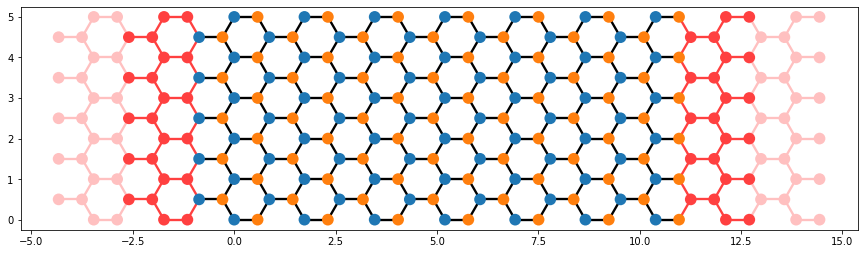

In [79]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_aspect('equal')
kwant.plot(system_test, ax=ax);

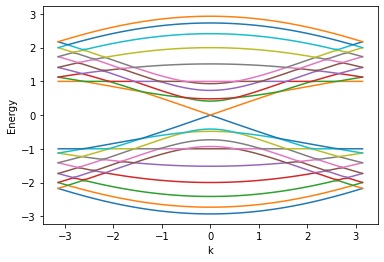

In [80]:
kwant.plotter.bands(lead0.finalized());